In [1]:
%load_ext autoreload
%autoreload 2
%reset -f

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import sys
import os

sys.dont_write_bytecode = True
# current_dir = os.getcwd()
# parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
# sys.path.append(parent_dir)

import src.visualisation as vis
from src.StocksDataset import StocksDataset
from src.EarlyStopping import EarlyStopping
from models.LSTM import LSTM
from src.DataPreprocessor import DataPreprocessor
from src.Testing import Testing

torch.manual_seed(123)

In [2]:
path = "./datasets/aapl.csv"
train_split_part = 0.8
lookback_days = 30
future_days = 5

data_preprocessor = DataPreprocessor(path)
scalers = data_preprocessor.z_score(cols_to_standardize=["Open", "High", "Low", "Close", "Volume"], train_split_part=train_split_part)
x, y = data_preprocessor.split_data(
    context_size=lookback_days,
    future_size=future_days,
    train_features=["Open", "High", "Low", "Close", "Volume"],
    features_to_predict=["Close"]
)
print(x.shape, y.shape)

(2480, 30, 5) (2480, 5, 1)


In [3]:
n = len(x)
split = int(0.8 * n)

train_dataset = StocksDataset(x[:split], y[:split])
test_dataset  = StocksDataset(x[split:], y[split:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

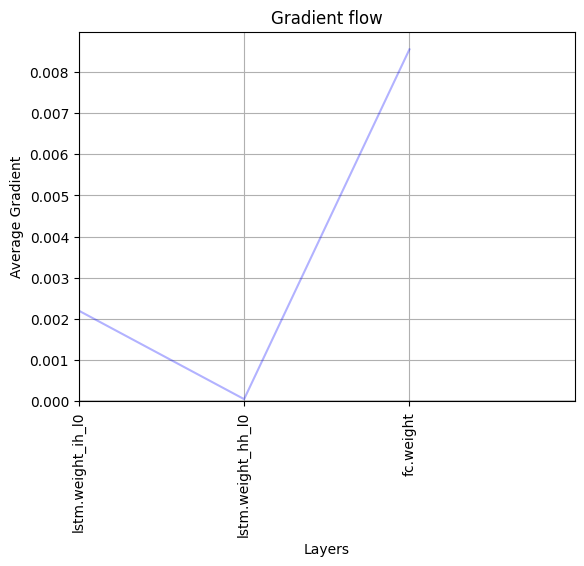

Epoch [5/5], Train loss: 0.010554, Validation loss: 0.033265


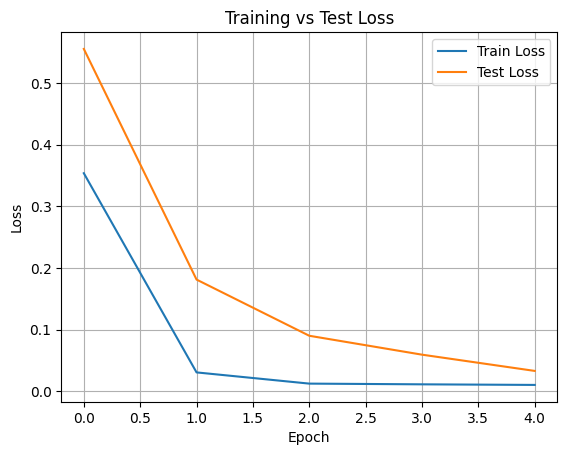

In [4]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

n_epochs = 5
plot_gradients = True

model = LSTM(
    input_size=5,
    hidden_size=512,
    num_layers=1,
    dropout=0.0,
    pred_days=future_days
).to(device)

criterion = nn.MSELoss()
#criterion = nn.HuberLoss(reduction='mean', delta=0.125)
#criterion = directional_loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses = []
test_losses = []
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(n_epochs):
    # ---- Train ----
    model.train()
    total_loss = 0
    _batch_counter = 0 # used to show gradients only once
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        total_loss += loss.item()
        loss.backward()

        if epoch == 0 and plot_gradients and _batch_counter == 0:
            vis.plot_grad_flow(model.named_parameters())

        optimizer.step()
        _batch_counter += 1

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    scheduler.step()

    # ---- Test ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_val_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Train loss: {avg_train_loss:.6f}, Validation loss: {avg_val_loss:.6f}")

    # ---- Early stopping ----
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print(f"Best loss: {early_stopping.best_loss}")
        model.load_state_dict(torch.load("model_weights.pt"))  # restore best weights
        break


vis.plot_losses(train_losses, test_losses)

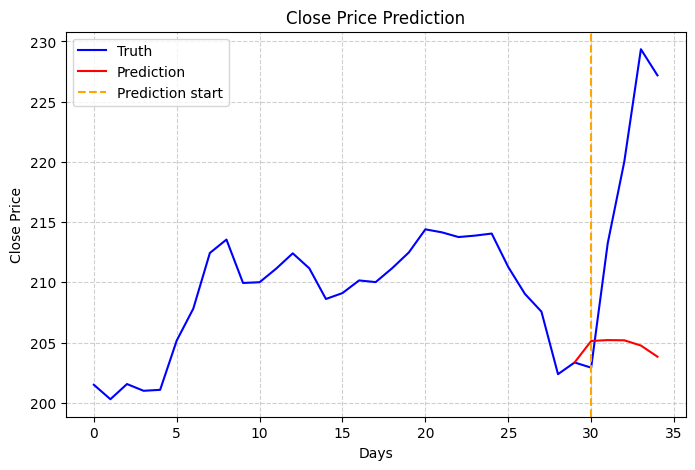

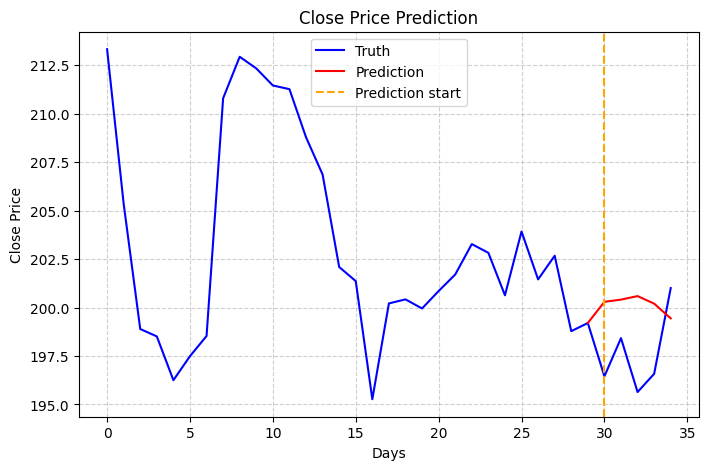

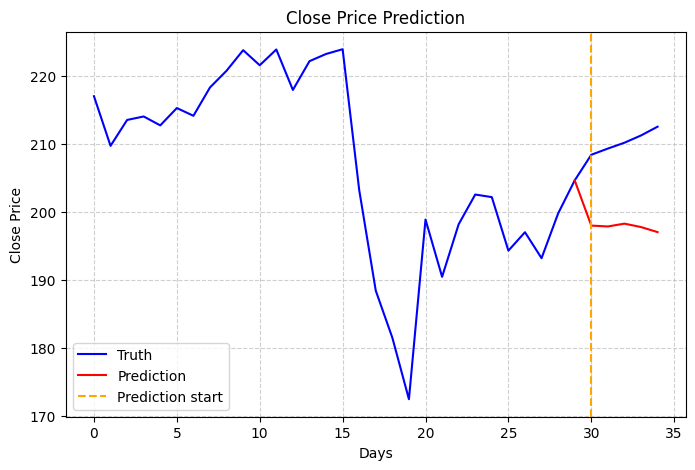

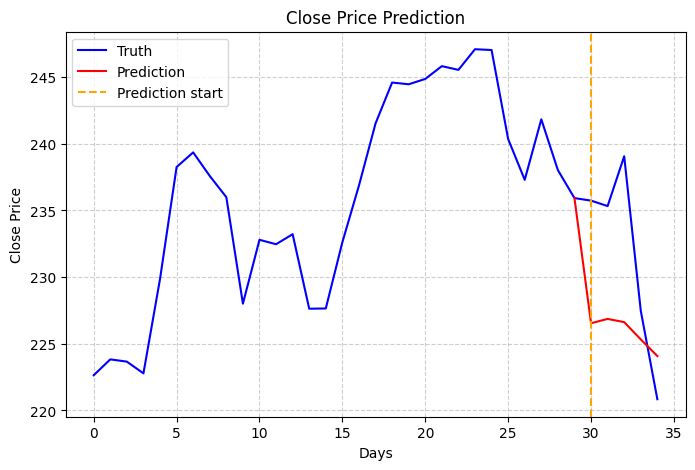

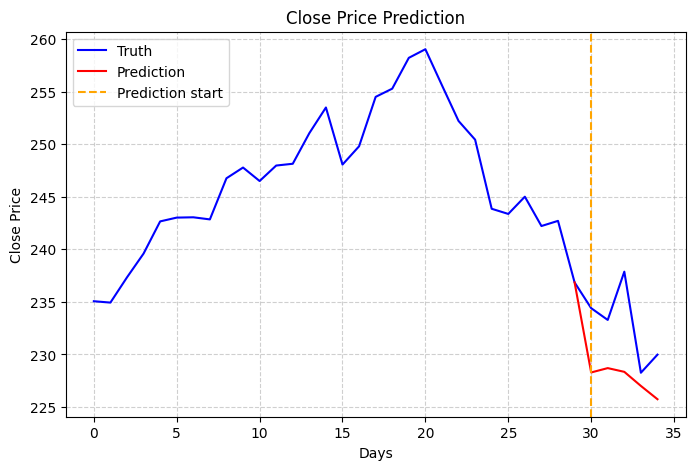

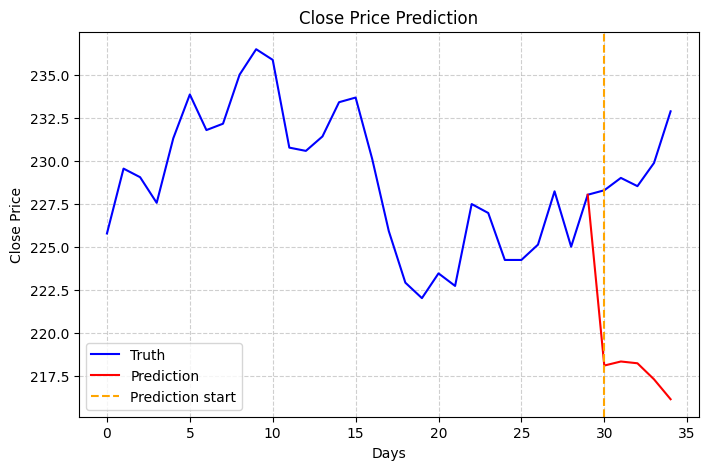

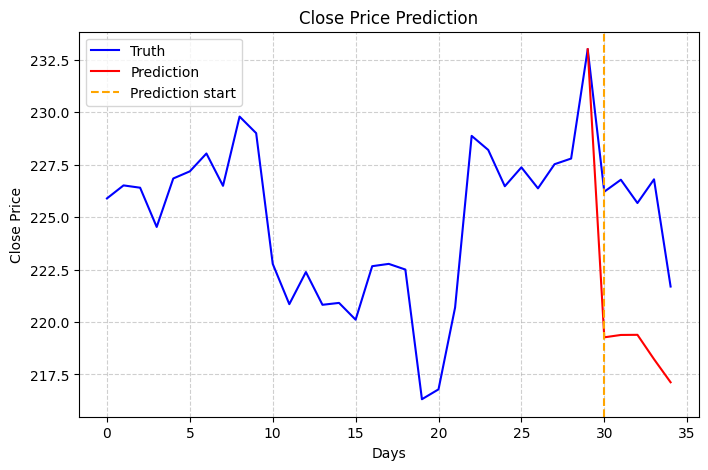

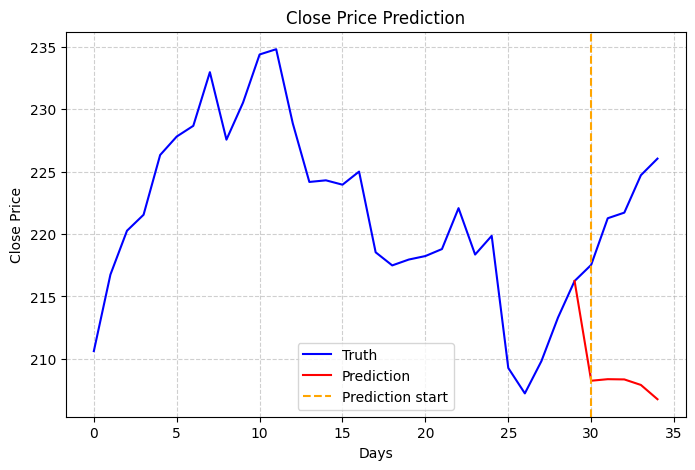

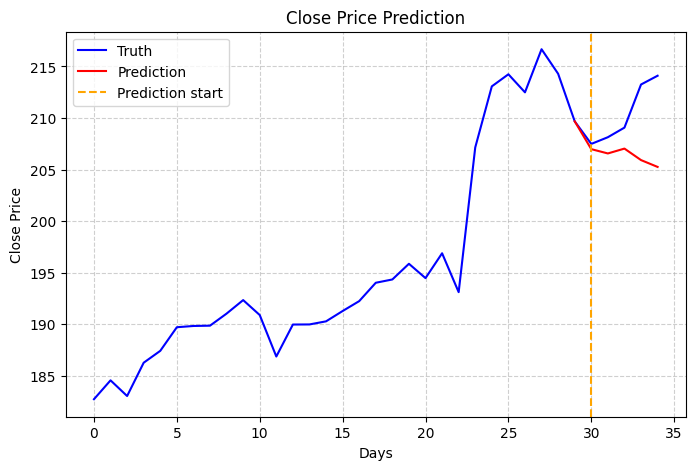

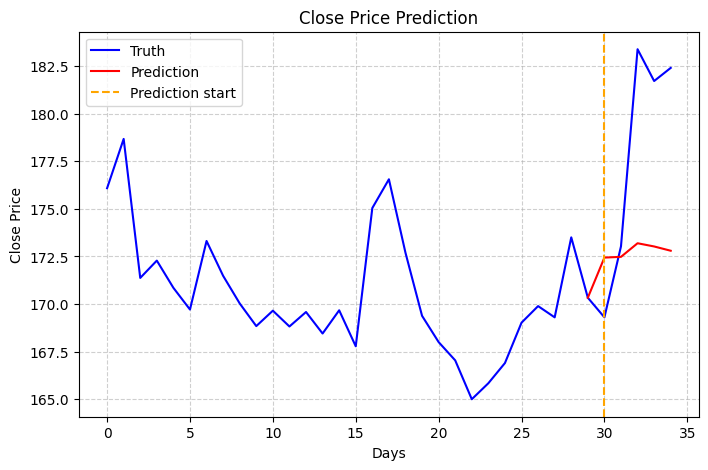

In [5]:
testing = Testing(model, device)
testing.get_n_last_prediction_windows(data_preprocessor.data_np, 10, lookback_days, future_days, scalers, "Close")